# Introduction to `tidyverse` Round 2
An ["opinionated" collection of R packages](https://tidyverse.org) for data science, driven by a coherent underlying design philosophy.
These packages are meant to help you with two essential processes:
1. **Data clean-up and organization**: Structure should be intuitive, so that it's easy to model, manipulate, and think about the data
2. **Data plotting**: The grammar of graphics (Week 13)

In [30]:
library(tidyverse)

## Data preparation

### Loading the data

In [31]:
data <- read_csv("data/148338_220209_095045_M057814.csv", skip=2)

Rows: 241 Columns: 32
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (21): type, stim1, stim2, stimPos, stimFormat, feedbackIncorrect, head, ...
dbl (11): rowNo, ITI, feedbackTime, random, ITI_ms, ITI_f, ITI_fDuration, ti...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [32]:
education_level <- data %>% pull(response) %>% first()  

data <- data %>%
    # Keep only useful columns
    select(c(rowNo, type, stim1, stim2, stimPos, trialType, response, RT)) %>%
    
    # Keep only useful rows
    filter(type != "form") %>%
    
    # Add demographic and trial-number info, turn trial type to factor
    mutate(
        education_level = education_level, # Add info
        trial_number = row_number(),
        trialType = factor(trialType, levels = c("incongruent", "congruent"))
    ) %>%
    
    # Rename trialType to trial_type
    rename(trial_type = trialType)

head(data)

rowNo,type,stim1,stim2,stimPos,trial_type,response,RT,education_level,trial_number
<dbl>,<chr>,<chr>,<chr>,<chr>,<fct>,<chr>,<dbl>,<chr>,<int>
190,test,croissantLarge,breadSmall,-341 0; 341 0,incongruent,j,729,College or Technical School,1
125,test,lampSmall,shelfLarge,-235 0; 235 0,congruent,f,625,College or Technical School,2
200,test,schoolbusLarge,bikeSmall,-370 0; 370 0,congruent,j,1477,College or Technical School,3
152,test,orangeLarge,raspberrySmall,-307 0; 307 0,congruent,j,793,College or Technical School,4
110,test,hammerLarge,ladderSmall,-156 0; 156 0,incongruent,j,900,College or Technical School,5
215,test,wheelSmall,coinLarge,-300 0; 300 0,incongruent,f,699,College or Technical School,6


### Tidying the data

Our data is almost tidy, but we still need to do several things.

#### Exercise 1
There are two columns that are uninformative. Remove them.

In [33]:
data_informative <- data |>
    select(-all_of(c("rowNo", "type")))

#### Exercise 2
The columns `stim1` and `stim2` refer to the stimulus presented on the left and, respectively, right. Rename the columns to make them more informative.

In [34]:
data_renamed <- data_informative |>
    rename(
        stim_left = stim1,
        stim_right = stim2
    )

#### Exercise 3
Add a new column called `subject_id` and set this participant to 1.

In [35]:
data_with_id <- data_renamed |>
    mutate(
        subject_id = 1
    )

head(data_with_id)

stim_left,stim_right,stimPos,trial_type,response,RT,education_level,trial_number,subject_id
<chr>,<chr>,<chr>,<fct>,<chr>,<dbl>,<chr>,<int>,<dbl>
croissantLarge,breadSmall,-341 0; 341 0,incongruent,j,729,College or Technical School,1,1
lampSmall,shelfLarge,-235 0; 235 0,congruent,f,625,College or Technical School,2,1
schoolbusLarge,bikeSmall,-370 0; 370 0,congruent,j,1477,College or Technical School,3,1
orangeLarge,raspberrySmall,-307 0; 307 0,congruent,j,793,College or Technical School,4,1
hammerLarge,ladderSmall,-156 0; 156 0,incongruent,j,900,College or Technical School,5,1
wheelSmall,coinLarge,-300 0; 300 0,incongruent,f,699,College or Technical School,6,1


#### Exercise 4
Add a new column called `correct_side`. This column should encode the side of the correct answer (equivalently, the side of the smaller image). Use `str_detect(string, pattern)` to compute where the smaller image was on the screen and use a conditional `mutate` to fill in the values of `correct_side`.

In [36]:
data_correct <- data_with_id |>
    mutate(
        correct_side = case_when(
            str_detect(stim_left, "Small") ~ "left",
            TRUE ~ "right"

        )
    )

head(data_correct)


stim_left,stim_right,stimPos,trial_type,response,RT,education_level,trial_number,subject_id,correct_side
<chr>,<chr>,<chr>,<fct>,<chr>,<dbl>,<chr>,<int>,<dbl>,<chr>
croissantLarge,breadSmall,-341 0; 341 0,incongruent,j,729,College or Technical School,1,1,right
lampSmall,shelfLarge,-235 0; 235 0,congruent,f,625,College or Technical School,2,1,left
schoolbusLarge,bikeSmall,-370 0; 370 0,congruent,j,1477,College or Technical School,3,1,right
orangeLarge,raspberrySmall,-307 0; 307 0,congruent,j,793,College or Technical School,4,1,right
hammerLarge,ladderSmall,-156 0; 156 0,incongruent,j,900,College or Technical School,5,1,right
wheelSmall,coinLarge,-300 0; 300 0,incongruent,f,699,College or Technical School,6,1,left


#### Exercise 5
Add a new column called `correct_key`. This column should be equal to `f` if the smaller image was on the left, and to `j` if the smaller image was on the right.

In [37]:
data_key <- data_correct |>
    mutate(
        correct_key = case_when(
            str_detect(correct_side, "left") ~ "f",
            TRUE ~ "j"

        )
    )

head(data_key)


stim_left,stim_right,stimPos,trial_type,response,RT,education_level,trial_number,subject_id,correct_side,correct_key
<chr>,<chr>,<chr>,<fct>,<chr>,<dbl>,<chr>,<int>,<dbl>,<chr>,<chr>
croissantLarge,breadSmall,-341 0; 341 0,incongruent,j,729,College or Technical School,1,1,right,j
lampSmall,shelfLarge,-235 0; 235 0,congruent,f,625,College or Technical School,2,1,left,f
schoolbusLarge,bikeSmall,-370 0; 370 0,congruent,j,1477,College or Technical School,3,1,right,j
orangeLarge,raspberrySmall,-307 0; 307 0,congruent,j,793,College or Technical School,4,1,right,j
hammerLarge,ladderSmall,-156 0; 156 0,incongruent,j,900,College or Technical School,5,1,right,j
wheelSmall,coinLarge,-300 0; 300 0,incongruent,f,699,College or Technical School,6,1,left,f


#### Exercise 6
Add a new column called `correct`. This column should be equal to 1 if the participant provided a correct response, 0 otherwise.

In [38]:
data_judge <- data_key |>
    mutate(
        correct = ifelse(response == correct_key, 1, 0)
    )

head(data_judge)

stim_left,stim_right,stimPos,trial_type,response,RT,education_level,trial_number,subject_id,correct_side,correct_key,correct
<chr>,<chr>,<chr>,<fct>,<chr>,<dbl>,<chr>,<int>,<dbl>,<chr>,<chr>,<dbl>
croissantLarge,breadSmall,-341 0; 341 0,incongruent,j,729,College or Technical School,1,1,right,j,1
lampSmall,shelfLarge,-235 0; 235 0,congruent,f,625,College or Technical School,2,1,left,f,1
schoolbusLarge,bikeSmall,-370 0; 370 0,congruent,j,1477,College or Technical School,3,1,right,j,1
orangeLarge,raspberrySmall,-307 0; 307 0,congruent,j,793,College or Technical School,4,1,right,j,1
hammerLarge,ladderSmall,-156 0; 156 0,incongruent,j,900,College or Technical School,5,1,right,j,1
wheelSmall,coinLarge,-300 0; 300 0,incongruent,f,699,College or Technical School,6,1,left,f,1


#### Exercise 7
The experiment had 240 trials, equally divided into two blocks. Add a new column called `trial_block` that encodes this.

In [39]:
block_n <- data_judge |> 
    mutate(
        trial_block = if_else(trial_number <= 120, 1, 2)
    )
block_n[115:125,]

stim_left,stim_right,stimPos,trial_type,response,RT,education_level,trial_number,subject_id,correct_side,correct_key,correct,trial_block
<chr>,<chr>,<chr>,<fct>,<chr>,<dbl>,<chr>,<int>,<dbl>,<chr>,<chr>,<dbl>,<dbl>
mouseLarge,lionSmall,-334 0; 334 0,incongruent,j,454,College or Technical School,115,1,right,j,1,1
mopedLarge,truckSmall,-312 0; 312 0,incongruent,j,1238,College or Technical School,116,1,right,j,1,1
carLarge,wheelbarrowSmall,-347 0; 347 0,congruent,j,602,College or Technical School,117,1,right,j,1,1
kittyLarge,donkeySmall,-317 0; 317 0,incongruent,j,433,College or Technical School,118,1,right,j,1,1
butterflyLarge,elephantSmall,-328 0; 328 0,incongruent,j,940,College or Technical School,119,1,right,j,1,1
shelfSmall,lampLarge,-235 0; 235 0,incongruent,f,872,College or Technical School,120,1,left,f,1,1
shelfLarge,lampSmall,-235 0; 235 0,congruent,j,673,College or Technical School,121,1,right,j,1,2
watermelonSmall,apricotLarge,-300 0; 300 0,incongruent,f,481,College or Technical School,122,1,left,f,1,2
mouseSmall,lionLarge,-334 0; 334 0,congruent,f,436,College or Technical School,123,1,left,f,1,2


#### Exercise 8
Recode `trial_number` so that it codes the trial number within a block. Instead of going from 1 to 240, it should go from 1 to 120 twice.

In [40]:
new_trial_n <- block_n |>
    mutate(
        trial_number = case_when(
            trial_block == 1 ~ trial_number,
            trial_block == 2 ~ trial_number - 120
        )
    )

new_trial_n[115:125,]

stim_left,stim_right,stimPos,trial_type,response,RT,education_level,trial_number,subject_id,correct_side,correct_key,correct,trial_block
<chr>,<chr>,<chr>,<fct>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>
mouseLarge,lionSmall,-334 0; 334 0,incongruent,j,454,College or Technical School,115,1,right,j,1,1
mopedLarge,truckSmall,-312 0; 312 0,incongruent,j,1238,College or Technical School,116,1,right,j,1,1
carLarge,wheelbarrowSmall,-347 0; 347 0,congruent,j,602,College or Technical School,117,1,right,j,1,1
kittyLarge,donkeySmall,-317 0; 317 0,incongruent,j,433,College or Technical School,118,1,right,j,1,1
butterflyLarge,elephantSmall,-328 0; 328 0,incongruent,j,940,College or Technical School,119,1,right,j,1,1
shelfSmall,lampLarge,-235 0; 235 0,incongruent,f,872,College or Technical School,120,1,left,f,1,1
shelfLarge,lampSmall,-235 0; 235 0,congruent,j,673,College or Technical School,1,1,right,j,1,2
watermelonSmall,apricotLarge,-300 0; 300 0,incongruent,f,481,College or Technical School,2,1,left,f,1,2
mouseSmall,lionLarge,-334 0; 334 0,congruent,f,436,College or Technical School,3,1,left,f,1,2


#### Exercise 9
It is good practice to use a consistent style throughout your script. One such style is called **snake**, the standard in python, which uses only lowercase letters and underscores: `variable_name`. Another common style is **camel**, the standard in JavaScript, which uses capital letters to mark the beginning of a new word: `variableName`. Our tibble at this point uses both styles, so turn all variable names to snake case. You can use `colnames` to see the vector of column names.

In [41]:
colnames(new_trial_n)
# Already snack-like

[1] "stim_left"       "stim_right"      "stimPos"         "trial_type"     
 [5] "response"        "RT"              "education_level" "trial_number"   
 [9] "subject_id"      "correct_side"    "correct_key"     "correct"        
[13] "trial_block"

#### Exercise 10
Using `select`, reorder the columns such that participant information comes first, followed by trial block and number, followed by trial info.

In [46]:


new_col_order <- new_trial_n %>%
  select(
    subject_id, education_level,   # participant info
    trial_block, trial_number,     # trial block & number
    stim_left, stim_right, stimPos, trial_type, response, RT, correct_side, correct_key, correct  # trial info
  )

head(new_col_order)

subject_id,education_level,trial_block,trial_number,stim_left,stim_right,stimPos,trial_type,response,RT,correct_side,correct_key,correct
<dbl>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<fct>,<chr>,<dbl>,<chr>,<chr>,<dbl>
1,College or Technical School,1,1,croissantLarge,breadSmall,-341 0; 341 0,incongruent,j,729,right,j,1
1,College or Technical School,1,2,lampSmall,shelfLarge,-235 0; 235 0,congruent,f,625,left,f,1
1,College or Technical School,1,3,schoolbusLarge,bikeSmall,-370 0; 370 0,congruent,j,1477,right,j,1
1,College or Technical School,1,4,orangeLarge,raspberrySmall,-307 0; 307 0,congruent,j,793,right,j,1
1,College or Technical School,1,5,hammerLarge,ladderSmall,-156 0; 156 0,incongruent,j,900,right,j,1
1,College or Technical School,1,6,wheelSmall,coinLarge,-300 0; 300 0,incongruent,f,699,left,f,1


#### Exercise 11
Concatenate all the commands in Exercises 1–10 into a single cell and store the output in a variable called `tidy_data`.

In [48]:
tidy_data <- read_csv("data/148338_220209_095045_M057814.csv", skip = 2) %>%
  # Extract participant info
  mutate(education_level = first(response)) %>%
  
  # Keep only relevant columns and rows
  select(rowNo, type, stim1, stim2, stimPos, trialType, response, RT, education_level) %>%
  filter(type != "form") %>%
  
  # Rename columns for clarity
  rename(
    stim_left = stim1,
    stim_right = stim2,
    trial_type = trialType
  ) %>%
  
  # Add trial number and subject ID
  mutate(
    trial_number = row_number(),
    subject_id = 1,
    trial_type = factor(trial_type, levels = c("incongruent", "congruent"))
  ) %>%
  
  # Compute correctness information
  mutate(
    correct_side = ifelse(str_detect(stim_left, "Small"), "left", "right"),
    correct_key = ifelse(correct_side == "left", "f", "j"),
    correct = ifelse(response == correct_key, 1, 0)
  ) %>%
  
  # Define trial blocks and recode trial numbers within block
  mutate(
    trial_block = if_else(trial_number <= 120, 1, 2),
    trial_number = if_else(trial_block == 1, trial_number, trial_number - 120)
  ) %>%
  
  # Reorder columns: participant info → trial identifiers → trial info
  select(
    subject_id, education_level,
    trial_block, trial_number,
    stim_left, stim_right, stimPos, trial_type, response, RT,
    correct_side, correct_key, correct
  )

head(tidy_data)

Rows: 241 Columns: 32
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (21): type, stim1, stim2, stimPos, stimFormat, feedbackIncorrect, head, ...
dbl (11): rowNo, ITI, feedbackTime, random, ITI_ms, ITI_f, ITI_fDuration, ti...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


subject_id,education_level,trial_block,trial_number,stim_left,stim_right,stimPos,trial_type,response,RT,correct_side,correct_key,correct
<dbl>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<fct>,<chr>,<dbl>,<chr>,<chr>,<dbl>
1,College or Technical School,1,1,croissantLarge,breadSmall,-341 0; 341 0,incongruent,j,729,right,j,1
1,College or Technical School,1,2,lampSmall,shelfLarge,-235 0; 235 0,congruent,f,625,left,f,1
1,College or Technical School,1,3,schoolbusLarge,bikeSmall,-370 0; 370 0,congruent,j,1477,right,j,1
1,College or Technical School,1,4,orangeLarge,raspberrySmall,-307 0; 307 0,congruent,j,793,right,j,1
1,College or Technical School,1,5,hammerLarge,ladderSmall,-156 0; 156 0,incongruent,j,900,right,j,1
1,College or Technical School,1,6,wheelSmall,coinLarge,-300 0; 300 0,incongruent,f,699,left,f,1


### Summary statistics

In [49]:
tidy_data %>%
    summarize(rt = mean(rt), accuracy = mean(correct), error = mean(1 - correct))

Warning message:
“There was 1 warning in `summarize()`.
ℹ In argument: `rt = mean(rt)`.
Caused by warning in `mean.default()`:
! l'argument n'est ni numérique, ni logique : renvoi de NA”


rt,accuracy,error
<dbl>,<dbl>,<dbl>
NA,0.9833333,0.01666667


In [50]:
tidy_data %>%
    mutate(avg_error = mean(1 - correct))

subject_id,education_level,trial_block,trial_number,stim_left,stim_right,stimPos,trial_type,response,RT,correct_side,correct_key,correct,avg_error
<dbl>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<fct>,<chr>,<dbl>,<chr>,<chr>,<dbl>,<dbl>
1,College or Technical School,1,1,croissantLarge,breadSmall,-341 0; 341 0,incongruent,j,729,right,j,1,0.01666667
1,College or Technical School,1,2,lampSmall,shelfLarge,-235 0; 235 0,congruent,f,625,left,f,1,0.01666667
1,College or Technical School,1,3,schoolbusLarge,bikeSmall,-370 0; 370 0,congruent,j,1477,right,j,1,0.01666667
1,College or Technical School,1,4,orangeLarge,raspberrySmall,-307 0; 307 0,congruent,j,793,right,j,1,0.01666667
1,College or Technical School,1,5,hammerLarge,ladderSmall,-156 0; 156 0,incongruent,j,900,right,j,1,0.01666667
1,College or Technical School,1,6,wheelSmall,coinLarge,-300 0; 300 0,incongruent,f,699,left,f,1,0.01666667
1,College or Technical School,1,7,coconutSmall,blueberryLarge,-309 0; 309 0,incongruent,f,752,left,f,1,0.01666667
1,College or Technical School,1,8,pumpkinLarge,mushroomSmall,-304 0; 304 0,congruent,j,567,right,j,1,0.01666667
1,College or Technical School,1,9,croissantSmall,breadLarge,-341 0; 341 0,congruent,f,556,left,f,1,0.01666667


#### Exercise 12
Using the `.by` argument in the call to `summarize`, find out if our participant showed the predicted size Stroop in reaction times and error rates.

In [52]:
tidy_data %>%
  summarize(
    mean_rt = mean(RT),
    error_rate = mean(1 - correct),
    .by = trial_type
  )


trial_type,mean_rt,error_rate
<fct>,<dbl>,<dbl>
incongruent,698.1000,0.03333333
congruent,547.4083,0.00000000


#### Exercise 13
Using a similar logic, find out if our participant also showed a SNARC effect: Was the participant faster when the small image was on the left?

In [53]:
tidy_data %>%
  summarize(
    mean_rt = mean(RT),
    .by = correct_side
  )

correct_side,mean_rt
<chr>,<dbl>
right,632.7333
left,612.7750


#### Exercise 14
Find out if the SNARC effect depends on trial type.

In [54]:
tidy_data %>%
  summarize(
    mean_rt = mean(RT),
    .by = c(trial_type, correct_side)
  ) %>%
  pivot_wider(
    names_from = correct_side,
    values_from = mean_rt
  ) %>%
  mutate(
    snarc_rt = right - left
  )


trial_type,right,left,snarc_rt
<fct>,<dbl>,<dbl>,<dbl>
incongruent,694.9167,701.2833,-6.366667
congruent,570.5500,524.2667,46.283333


## From a single participant to a full dataset
We load all the 12 csv files in the 'data' folder, then apply the `read_csv` function to each of them using `map_dfr`. The `.id` argument creates a column that keeps the information from each file separate. This is equivalent to having a subject_id, if there is one .csv file per participant.

In [55]:
# Fetch all the files in the 'data' folder that end in .csv
raw_data <- list.files(path = 'data', pattern = ".csv$", full.names = TRUE) %>% 

  # Map the read_csv function to all of them, skipping the first 2 rows and creating a new id column called 'id' so that each file gets its own id
  # col_types = cols() just makes explicit that you want tidyverse to do its best to guess the type of each column (string, numeric, etc.)
  map_dfr(read_csv, col_types = cols(), skip = 2, .id = 'id') 

#### Exercise 15
Tidy the dataset exactly as we did for subject 1, while keeping the education-level information for each subject. Store it as `tidy_data`.

Hint: **group** the tibble before calling `first(response)`), then follow the same steps as before to obtain a tidy dataset. Use `ungroup()` to return to the tibble to the ungrouped state. In fact, in most of the exercises that follow, you will need to use grouping wisely.

```R
full_data <- raw_data %>% 
    mutate(education_level = first(response), .by = id) %>%
    ...
```

In [56]:
tidy_data <- raw_data %>%
  
  # Get education level per subject
  mutate(education_level = first(response), .by = id) %>%
  
  # Keep useful columns only
  select(id, rowNo, type, stim1, stim2, stimPos, trialType, response, RT, education_level) %>%
  
  # Remove non-trial rows
  filter(type != "form") %>%
  
  # Rename variables
  rename(
    stim_left  = stim1,
    stim_right = stim2,
    trial_type = trialType
  ) %>%
  
  # Add trial info
  mutate(
    trial_number = row_number(),
    trial_type = factor(trial_type, levels = c("incongruent", "congruent"))
  ) %>%
  
  # Compute correctness
  mutate(
    correct_side = if_else(str_detect(stim_left, "Small"), "left", "right"),
    correct_key  = if_else(correct_side == "left", "f", "j"),
    correct      = if_else(response == correct_key, 1, 0)
  ) %>%
  
  # Define blocks and renumber trials within block
  mutate(
    trial_block  = if_else(trial_number <= 120, 1, 2),
    trial_number = if_else(trial_block == 1, trial_number, trial_number - 120)
  ) %>%
  
  # Final column order
  select(
    id, education_level,
    trial_block, trial_number,
    stim_left, stim_right, stimPos, trial_type,
    response, RT,
    correct_side, correct_key, correct
  )


#### Exercise 16
Trials where the responses were too slow or too fast should be excluded from the analysis. (Why?)  
Exclude the trials where the response is below 200 ms or higher than 1,500 ms. How many trials were excluded?

In [57]:
# Count excluded trials (RT < 200 ms or RT > 1500 ms)
n_excluded <- tidy_data %>%
  filter(RT < 200 | RT > 1500) %>%
  nrow()

# Exclude those trials
tidy_data <- tidy_data %>%
  filter(RT >= 200, RT <= 1500)

n_excluded


[1] 284

#### Exercise 17 
Exclude participants who didn't achieve 93% overall accuracy.  
How many subjects were excluded?

In [58]:
# Identify participants with overall accuracy < 93%
excluded_subjects <- tidy_data %>%
  summarize(accuracy = mean(correct), .by = id) %>%
  filter(accuracy < 0.93)

# Number of excluded participants
n_excluded_subjects <- nrow(excluded_subjects)

# Exclude them from the dataset
tidy_data <- tidy_data %>%
  filter(!id %in% excluded_subjects$id)

n_excluded_subjects


[1] 1

#### Exercise 18
Summarize the response-time and accuracy measures by trial type to check whether there's a Stroop effect.

In [59]:
tidy_data %>%
  summarize(
    mean_rt = mean(RT),
    accuracy = mean(correct),
    .by = trial_type
  )


trial_type,mean_rt,accuracy
<fct>,<dbl>,<dbl>
incongruent,814.4211,0.935289
congruent,707.7510,0.994152


## Changing the format of the data: `pivot_wider`, `pivot_longer`

#### Exercise 19: `pivot_wider`
Compute the average Stroop effects for each participant. One column should be called `stroop_rt`, the other should be called `stroop_error`. Using `pull`, extract the reaction-time Stroop vector and plot its histogram.

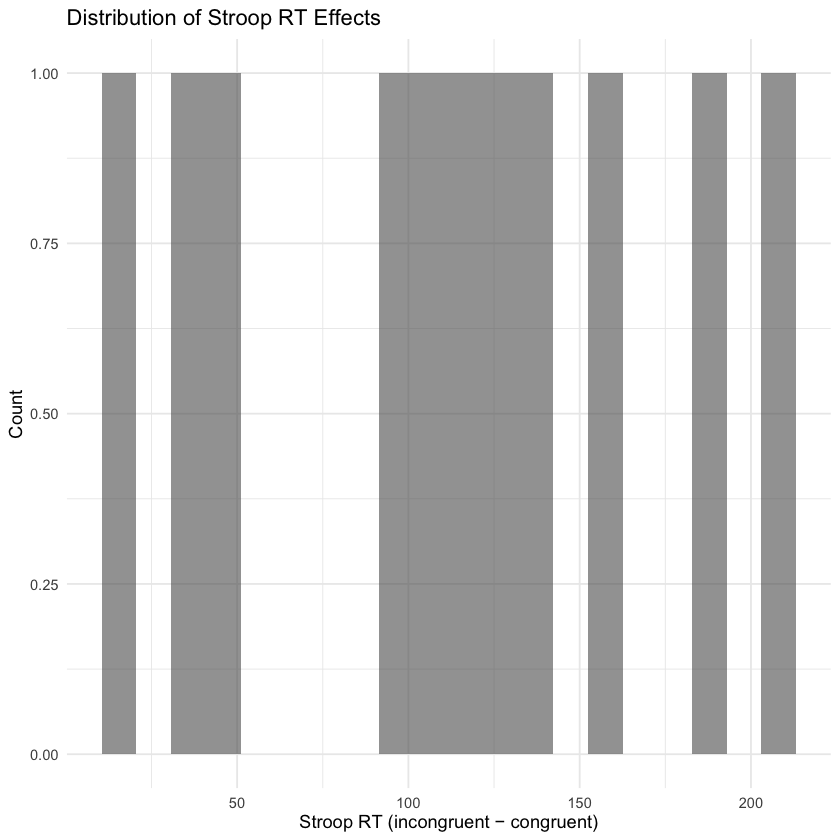

In [60]:
# Compute Stroop effects per participant
stroop_data <- tidy_data %>%
  summarize(
    mean_rt = mean(RT),
    error_rate = mean(1 - correct),
    .by = c(id, trial_type)
  ) %>%
  pivot_wider(
    names_from = trial_type,
    values_from = c(mean_rt, error_rate)
  ) %>%
  mutate(
    stroop_rt    = mean_rt_incongruent - mean_rt_congruent,
    stroop_error = error_rate_incongruent - error_rate_congruent
  )

# Extract Stroop RT vector
stroop_rt_vec <- stroop_data %>%
  pull(stroop_rt)

# Plot histogram of Stroop RT effects
ggplot(data.frame(stroop_rt = stroop_rt_vec), aes(x = stroop_rt)) +
  geom_histogram(bins = 20, alpha = 0.6) +
  theme_minimal() +
  labs(
    title = "Distribution of Stroop RT Effects",
    x = "Stroop RT (incongruent − congruent)",
    y = "Count"
  )


#### Exercise 20: `pivot_longer`
Building on the output tibble in Exercise 19, remove all columns except `id`, `stroop_rt`, and `stroop_error`, then gather the two stroop columns into a single column called `measure`. This column should take one of two values for each subject (`stroop_rt` or `stroop_error`), while the `value` column should register the respective participants' stroop effect.

In [62]:
stroop_long <- stroop_data %>%
  select(id, stroop_rt, stroop_error) %>%
  pivot_longer(
    cols = c(stroop_rt, stroop_error),
    names_to = "measure",
    values_to = "value"
  )

stroop_long

id,measure,value
<chr>,<chr>,<dbl>
1,stroop_rt,136.54929379
1,stroop_error,0.03389831
2,stroop_rt,15.50925926
2,stroop_error,0.06481481
3,stroop_rt,126.06837607
3,stroop_error,0.08547009
5,stroop_rt,156.03347441
5,stroop_error,0.10619469
6,stroop_rt,115.42300195


## Data plotting

### Rule 1: If your data is in the tidy format (one variable per column, one observation per row), plotting with `ggplot` will be very easy.

### Rule 2: No barplots.

### One possible way to do it

In [63]:
average_data <- full_data %>% summarize(rt = mean(rt), .by = c(id, trial_type)) 

ggplot(average_data, aes(x = trial_type, y = rt, fill = trial_type)) +
  geom_boxplot(width = 0.5, alpha = 0.45) +
  geom_point(size = 2) +
  geom_line(aes(group = id), color = 'gray') +         
  stat_summary(fun.data = mean_se, linewidth = 2, shape = 21, size = 1.5) +
  labs(title = "Average reaction times by trial type (ms)", x = "Trial type", y = "") +
  theme_minimal() + 
  theme(
    legend.position = "none", 
    plot.title = element_text(face = "bold", size = 20),
    axis.title = element_text(size = 18),
    axis.text = element_text(size = 16))

ERROR: Error: objet 'full_data' introuvable
